In [ ]:
import numpy as np
import pandas as pd
import lifelines
import pandas_profiling as pp
import datetime as dt
import seaborn as sns

In [ ]:
from imblearn import over_sampling
from sklearn.model_selection import *
from sklearn.metrics import *

In [ ]:
from xgboost import XGBClassifier

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
supplementary = pd.read_csv('supplementary_data.csv')
sample = pd.read_csv('sample_submission.csv')

In [ ]:
pp.ProfileReport(train)

In [ ]:
pp.ProfileReport(supplementary)

# Cleaning Data

## Merge Supplementary Data

In [ ]:
df_train = train.merge(supplementary,on='driver_id')

In [ ]:
df_train.drop_duplicates(inplace=True)

In [ ]:
df_train.head()

driver_id        date  total_transcations  total_distance  \
0    140590065  2016-08-11                   0             0.0   
28   140590065  2016-08-18                   0             0.0   
56   140590065  2016-08-24                   0             0.0   
84   140590065  2016-08-04                   0             0.0   
112  140590065  2016-08-16                   0             0.0   

     online_duration_in_seconds  orders_received  orders_accepted  earnings  \
0                         13327               25                0       0.0   
28                            1                0                0       0.0   
56                           52                1                0       0.0   
84                            0                0                0       0.0   
112                           0                0                0       0.0   

     orders_cancelled  label gender  birth_date first_active  
0                   0      0      F  1994-05-11   2016-07-13  
28                  0      0      F  1994-05-11   2016-07-13  
56                  0      0      F  1994-05-11   2016-07-13  
84                  0      0      F  1994-05-11   2016-07-13  
112                 0      0      F  1994-05-11   2016-07-13

## Date

In [ ]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_train['first_active'] = pd.to_datetime(df_train['first_active'])
df_train['age_as_driver'] = df_train['date'] - df_train['first_active']
df_train['week'] = df_train['date'].apply(lambda x: x.week) - 30

In [ ]:
df_train['age_as_driver'] = df_train['age_as_driver'].dt.days

In [ ]:
df_train[(df_train['driver_id'] ==140644381)].sort_values('date')

driver_id       date  total_transcations  total_distance  \
5770  140644381 2016-08-01                   2           56.13   
6274  140644381 2016-08-02                   0            0.00   
5854  140644381 2016-08-03                   4           98.94   
5686  140644381 2016-08-04                   5           96.42   
5742  140644381 2016-08-05                   6          141.34   
5966  140644381 2016-08-06                   0            0.00   
5882  140644381 2016-08-07                   1           35.00   
6022  140644381 2016-08-08                   0            0.00   
5994  140644381 2016-08-09                   0            0.00   
6078  140644381 2016-08-10                   0            0.00   
5602  140644381 2016-08-11                   0            0.00   
6106  140644381 2016-08-12                   0            0.00   
6218  140644381 2016-08-13                   0            0.00   
6050  140644381 2016-08-14                   0            0.00   
5798  140644381 2016-08-15                   0            0.00   
5714  140644381 2016-08-16                   1           26.15   
6162  140644381 2016-08-17                   0            0.00   
5630  140644381 2016-08-18                   0            0.00   
6302  140644381 2016-08-19                   1           16.91   
6134  140644381 2016-08-20                   0            0.00   
5826  140644381 2016-08-21                   0            0.00   
6246  140644381 2016-08-22                   1           10.46   
6190  140644381 2016-08-23                   2           37.60   
5658  140644381 2016-08-24                   4           32.34   
5910  140644381 2016-08-25                   5           70.27   
5938  140644381 2016-08-26                   4           51.95   
6330  140644381 2016-08-27                   0            0.00   
6358  140644381 2016-08-28                   0            0.00   

      online_duration_in_seconds  orders_received  orders_accepted  earnings  \
5770                       16429                9                3  228850.0   
6274                           0                0                0       0.0   
5854                       23086                6                5  362250.0   
5686                       20228               30               14  382950.0   
5742                       19347               24               13  552000.0   
5966                          53                0                0       0.0   
5882                       11308               17                5   67850.0   
6022                        2719                0                0       0.0   
5994                       10545                6                2       0.0   
6078                        3563                8                1       0.0   
5602                       25636               29                2       0.0   
6106                           0                0                0       0.0   
6218                           0                0                0       0.0   
6050                           0                0                0       0.0   
5798                        2575                0                0       0.0   
5714                       18349               15                4  105800.0   
6162                           0                0                0       0.0   
5630                       32551                4                1       0.0   
6302                       26898                8                2   55200.0   
6134                           0                0                0       0.0   
5826                        1452                0                0       0.0   
6246                       17961                2                1   42550.0   
6190                       20543               25                6  174800.0   
5658                       11932               16                6  103500.0   
5910                       18941               42               10  311650.0   
5938       

## Cleaning

In [ ]:
df_train.drop(['birth_date','gender'],inplace=True,axis=1)

In [ ]:
df_train.dropna(inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54198 entries, 0 to 1473228
Data columns (total 13 columns):
driver_id                     54198 non-null int64
date                          54198 non-null datetime64[ns]
total_transcations            54198 non-null int64
total_distance                54198 non-null float64
online_duration_in_seconds    54198 non-null int64
orders_received               54198 non-null int64
orders_accepted               54198 non-null int64
earnings                      54198 non-null float64
orders_cancelled              54198 non-null int64
label                         54198 non-null int64
first_active                  54198 non-null datetime64[ns]
age_as_driver                 54198 non-null float64
week                          54198 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(8)
memory usage: 5.8 MB


In [ ]:
df_train[df_train['first_active']>df_train['date']].sort_values('date')

driver_id       date  total_transcations  total_distance  \
1465788  140659966 2016-08-01                   1           11.29   
1472642  140629675 2016-08-01                   0            0.00   
1456799  140601444 2016-08-01                   0            0.00   
1041629  140649130 2016-08-01                   0            0.00   
1458862  140653478 2016-08-01                   0            0.00   
333995   140658582 2016-08-01                   0            0.00   
945548   140530008 2016-08-01                   0            0.00   
903296   140637173 2016-08-01                   1            1.68   
1462190  140639544 2016-08-01                   0            0.00   
528481   140576806 2016-08-01                   0            0.00   
843971   140654195 2016-08-01                   0            0.00   
1462686  140660834 2016-08-01                   0            0.00   
1472104  140486802 2016-08-01                   0            0.00   
1464656  140620364 2016-08-01                   0            0.00   
616141   140655858 2016-08-01                   0            0.00   
778311   140653470 2016-08-01                   1            2.12   
1467398  140597700 2016-08-01                   0            0.00   
1471352  140567022 2016-08-01                   0            0.00   
630535   140569887 2016-08-01                   0            0.00   
654839   140304949 2016-08-01                   0            0.00   
1467466  140642954 2016-08-01                   0            0.00   
1467694  140654038 2016-08-01                   1           20.43   
1052891  140608908 2016-08-01                   0            0.00   
170401   140650651 2016-08-01                   0            0.00   
1468689  140517362 2016-08-01                   0            0.00   
1417459  140645677 2016-08-01                   0            0.00   
1367127  140660459 2016-08-01                   1            2.71   
70157    140656144 2016-08-01                   0            0.00   
1324372  140662349 2016-08-01                   0            0.00   
1190346  140658977 2016-08-01                   0            0.00   
...            ...        ...                 ...             ...   
1467406  140597700 2016-08-21                   0            0.00   
1397142  140631428 2016-08-22                   0            0.00   
1470565  140684154 2016-08-22                   0            0.00   
1456911  140601444 2016-08-22                   0            0.00   
655315   140304949 2016-08-22                   0            0.00   
1462302  140639544 2016-08-22                   0            0.00   
1044412  140678367 2016-08-23                   0            0.00   
1456883  140601444 2016-08-23                   0            0.00   
655259   140304949 2016-08-23                   0            0.00   
1397058  140631428 2016-08-24                   0            0.00   
1462176  140639544 2016-08-24                   0            0.00   
602668   140530629 2016-08-24                   0            0.00   
1467382  140597700 2016-08-24                   0            0.00   
1468359  140655252 2016-08-24                   0            0.00   
654727   140304949 2016-08-24                   0            0.00   
1462218  140639544 2016-08-25                   0            0.00   
280609   140686590 2016-08-25                   0            0.00   
1468373  140655252 2016-08-25                   0            0.00   
654979   140304949 2016-08-25                   0            0.00   
1397082  140631428 2016-08-25                   1           15.79   
1467414  140597700 2016-08-26                   1            4.73   
655007   140304949 2016-08-26                   1            9.87   
1473188  140517358 2016-08-27                   0            0.00   
1456925  140601444 2016-08-27                   0            0.00   
1473210  140686242 2016-08-27                   0            0.00   
1462330  140639544 2016-08-27                   1            0.67   
602692 

In [ ]:
df_train = df_train[df_train['age_as_driver']>0]

## Build Train Dataframe

In [ ]:
params_to_use = ['total_transcations', 'total_distance', 'online_duration_in_seconds', 
                 'orders_received', 'orders_accepted', 'earnings', 'orders_cancelled',]

weekly_train = df_train[['driver_id']]
for i in params_to_use:
    for j in range(1,5):
        temp = df_train[df_train['week']==j].groupby(['driver_id']).agg({i:['sum','mean','median']}).add_suffix(j)
        weekly_train = pd.merge(weekly_train,temp,on=['driver_id'])

weekly_train.drop_duplicates(inplace=True)

/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/c

In [ ]:
weekly_train = pd.merge(weekly_train,df_train[['driver_id','label']],on='driver_id')
weekly_train.drop_duplicates(inplace=True)

In [ ]:
weekly_train.head().T

0             28  \
driver_id                               1.405901e+08  1.406144e+08   
(total_transcations1, sum1)             0.000000e+00  1.000000e+00   
(total_transcations1, mean1)            0.000000e+00  1.666667e-01   
(total_transcations1, median1)          0.000000e+00  0.000000e+00   
(total_transcations2, sum2)             0.000000e+00  0.000000e+00   
(total_transcations2, mean2)            0.000000e+00  0.000000e+00   
(total_transcations2, median2)          0.000000e+00  0.000000e+00   
(total_transcations3, sum3)             0.000000e+00  0.000000e+00   
(total_transcations3, mean3)            0.000000e+00  0.000000e+00   
(total_transcations3, median3)          0.000000e+00  0.000000e+00   
(total_transcations4, sum4)             1.000000e+00  0.000000e+00   
(total_transcations4, mean4)            1.428571e-01  0.000000e+00   
(total_transcations4, median4)          0.000000e+00  0.000000e+00   
(total_distance1, sum1)                 0.000000e+00  9.140000e+00   
(total_distance1, mean1)                0.000000e+00  1.523333e+00   
(total_distance1, median1)              0.000000e+00  0.000000e+00   
(total_distance2, sum2)                 0.000000e+00  0.000000e+00   
(total_distance2, mean2)                0.000000e+00  0.000000e+00   
(total_distance2, median2)              0.000000e+00  0.000000e+00   
(total_distance3, sum3)                 0.000000e+00  0.000000e+00   
(total_distance3, mean3)                0.000000e+00  0.000000e+00   
(total_distance3, median3)              0.000000e+00  0.000000e+00   
(total_distance4, sum4)                 2.219000e+01  0.000000e+00   
(total_distance4, mean4)                3.170000e+00  0.000000e+00   
(total_distance4, median4)              0.000000e+00  0.000000e+00   
(online_duration_in_seconds1, sum1)     2.222000e+03  2.553800e+04   
(online_duration_in_seconds1, mean1)    3.174286e+02  4.256333e+03   
(online_duration_in_seconds1, median1)  0.000000e+00  2.934500e+03   
(online_duration_in_seconds2, sum2)     1.696500e+04  1.417100e+04   
(online_duration_in_seconds2, mean2)    2.423571e+03  4.723667e+03   
...                                              ...           ...   
(orders_accepted3, mean3)               0.000000e+00  0.000000e+00   
(orders_accepted3, median3)             0.000000e+00  0.000000e+00   
(orders_accepted4, sum4)                4.000000e+00  0.000000e+00   
(orders_accepted4, mean4)               5.714286e-01  0.000000e+00   
(orders_accepted4, median4)             0.000000e+00  0.000000e+00   
(earnings1, sum1)                       0.000000e+00  3.680000e+04   
(earnings1, mean1)                      0.000000e+00  6.133333e+03   
(earnings1, median1)                    0.000000e+00  0.000000e+00   
(earnings2, sum2)                       0.000000e+00  0.000000e+00   
(earnings2, mean2)                      0.000000e+00  0.000000e+00   
(earnings2, median2)                    0.000000e+00  0.000000e+00   
(earnings3, sum3)                       0.000000e+00  0.000000e+00   
(earnings3, mean3)                      0.000000e+00  0.000000e+00   
(earnings3, median3)                    0.000000e+00  0.000000e+00   
(earnings4, sum4)                       1.150000e+05  0.000000e+00   
(earnings4, mean4)                      1.642857e+04  0.000000e+00   
(earnings4, median4)                    0.000000e+00  0.000000e+00   
(orders_cancelled1, sum1)               1.000000e+00  0.000000e+00   
(orders_cancelled1, mean1)              1.428571e-01  0.000000e+00   
(orders_cancelled1, median1)            0.000000e+00  0.000000e+00   
(orders_cancelled2, sum2)               0.000000e+00  0.000000e+00   
(orders_cancelled2, mean2)              0.000000e+00  0.000000e+00   
(orders_cancelled2, median2)            0.000000e+00  0.000000e+00   
(orders_cancelled3, sum3)               0.000000e+00  0.000000e+00   
(orders_cancelled3, mean3)              0.000000e+00  0.000000e+00   
(orders_cancelled3, median3)            0.000000e+00  0.0000

In [ ]:
sns.scatterplot(x='age_as_driver',y='online_duration_in_seconds',hue='label', data=weekly_train)

ValueError: Could not interpret input 'age_as_driver'

In [ ]:
weekly_train.head()

driver_id  (total_transcations1, sum1)  (total_transcations1, mean1)  \
0   140590065                            0                      0.000000   
28  140614395                            1                      0.166667   
40  140468367                            1                      0.142857   
68  140447713                            0                      0.000000   
96  140486116                            0                      0.000000   

    (total_transcations1, median1)  (total_transcations2, sum2)  \
0                              0.0                            0   
28                             0.0                            0   
40                             0.0                            6   
68                             0.0                            0   
96                             0.0                            0   

    (total_transcations2, mean2)  (total_transcations2, median2)  \
0                       0.000000                             0.0   
28                      0.000000                             0.0   
40                      0.857143                             1.0   
68                      0.000000                             0.0   
96                      0.000000                             0.0   

    (total_transcations3, sum3)  (total_transcations3, mean3)  \
0                             0                      0.000000   
28                            0                      0.000000   
40                            6                      0.857143   
68                            0                      0.000000   
96                            0                      0.000000   

    (total_transcations3, median3)  ...    (orders_cancelled2, sum2)  \
0                              0.0  ...                            0   
28                             0.0  ...                            0   
40                             1.0  ...                            7   
68                             0.0  ...                            0   
96                             0.0  ...                            0   

    (orders_cancelled2, mean2)  (orders_cancelled2, median2)  \
0                          0.0                           0.0   
28                         0.0                           0.0   
40                         1.0                           1.0   
68                         0.0                           0.0   
96                         0.0                           0.0   

    (orders_cancelled3, sum3)  (orders_cancelled3, mean3)  \
0                           0                    0.000000   
28                          0                    0.000000   
40                          5                    0.714286   
68                          0                    0.000000   
96                          0                    0.000000   

    (orders_cancelled3, median3)  (orders_cancelled4, sum4)  \
0                            0.0                          3   
28                           0.0                          0   
40                           1.0                          9   
68                           0.0                          0   
96                           0.0                          0   

    (orders_cancelled4, mean4)  (orders_cancelled4, median4)  label  
0                     0.428571                           0.0      0  
28                    0.000000                           0.0      0  
40                    1.285714                           1.0      0  
68                    0.000000                           0.0      0  
96                    0.000000                           0.0      0  

[5 rows x 86 columns]

In [ ]:
weekly_train.rename(columns='_'.join, inplace=True)
weekly_train.rename(columns={'d_r_i_v_e_r___i_d' : 'driver_id', 'l_a_b_e_l' : 'label'},inplace=True)


In [ ]:
weekly_train.to_csv('weekly_train3.csv',index=False)

In [ ]:
df_train['driver_id'].nunique()

2047

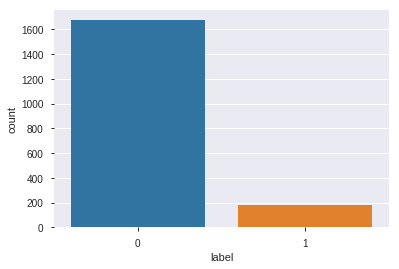

In [ ]:
sns.countplot(weekly_train['label'])

## Imbalanced Dataset

In [ ]:
sm = over_sampling.SMOTE(random_state=42)

In [ ]:
X,y = weekly_train.drop(['driver_id','label'],axis=1),weekly_train['label']

In [ ]:
X_res,y_res = sm.fit_resample(X,y)

In [ ]:
X_res.shape

(3346, 84)

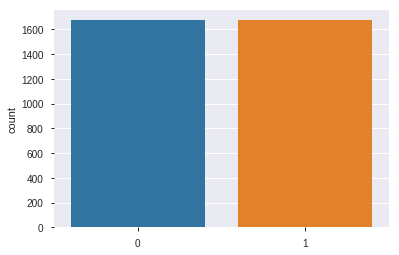

In [ ]:
sns.countplot(y_res)

## Building Model

In [ ]:
xgbc = XGBClassifier()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res)

In [ ]:
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [ ]:
y_preds = xgbc.predict(X_test)

In [ ]:
roc_auc_score(y_test,y_preds)

0.8958702587734846

## DF Test

In [ ]:
## Merge Supplementary Data

df_test = test.merge(supplementary,on='driver_id')

df_test.drop_duplicates(inplace=True)

df_test.head()

## Date

df_test['date'] = pd.to_datetime(df_test['date'])
df_test['first_active'] = pd.to_datetime(df_test['first_active'])
df_test['age_as_driver'] = df_test['date'] - df_test['first_active']
df_test['week'] = df_test['date'].apply(lambda x: x.week) - 30

df_test['age_as_driver'] = df_test['age_as_driver'].dt.days

## Cleaning

df_test.drop(['birth_date','gender'],inplace=True,axis=1)

df_test.info()

df_test[df_test['first_active']>df_test['date']].sort_values('date')


## Build test Dataframe

params_to_use = ['total_transcations', 'total_distance', 'online_duration_in_seconds', 
                 'orders_received', 'orders_accepted', 'earnings', 'orders_cancelled',]

weekly_test = df_test[['driver_id']]
for i in params_to_use:
    for j in range(1,5):
        temp = df_test[df_test['week']==j].groupby(['driver_id']).agg({i:['sum','mean','median']}).add_suffix(j)
        weekly_test = pd.merge(weekly_test,temp,on=['driver_id'])

# weekly_test.drop_duplicates(inplace=True)
# print(weekly_test['driver_id'].nunique())
weekly_test = pd.merge(df_test[['driver_id']],weekly_test,on='driver_id',how='left')
weekly_test.drop_duplicates(inplace=True)
print(len(weekly_test))
weekly_test.head().T


weekly_test.head()

weekly_test.rename(columns='_'.join, inplace=True)
weekly_test.rename(columns={'d_r_i_v_e_r___i_d' : 'driver_id'},inplace=True)


weekly_test.to_csv('weekly_test3.csv',index=False)

weekly_test['driver_id'].nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29075 entries, 0 to 790435
Data columns (total 12 columns):
driver_id                     29075 non-null int64
date                          29075 non-null datetime64[ns]
total_transcations            29075 non-null int64
total_distance                29075 non-null float64
online_duration_in_seconds    29075 non-null int64
orders_received               29075 non-null int64
orders_accepted               29075 non-null int64
earnings                      29075 non-null float64
orders_cancelled              29075 non-null int64
first_active                  29041 non-null datetime64[ns]
age_as_driver                 29041 non-null float64
week                          29075 non-null int64
dtypes: datetime64[ns](2), float64(3), int64(7)
memory usage: 2.9 MB


/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
/home/shadieq/anaconda3/lib/python3.7/site-packages/pandas/c

1115


1115

In [ ]:
weekly_test.fillna(0,inplace=True)

In [ ]:
weekly_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 772667
Data columns (total 85 columns):
driver_id                              1115 non-null int64
total_transcations1_sum1               1115 non-null float64
total_transcations1_mean1              1115 non-null float64
total_transcations1_median1            1115 non-null float64
total_transcations2_sum2               1115 non-null float64
total_transcations2_mean2              1115 non-null float64
total_transcations2_median2            1115 non-null float64
total_transcations3_sum3               1115 non-null float64
total_transcations3_mean3              1115 non-null float64
total_transcations3_median3            1115 non-null float64
total_transcations4_sum4               1115 non-null float64
total_transcations4_mean4              1115 non-null float64
total_transcations4_median4            1115 non-null float64
total_distance1_sum1                   1115 non-null float64
total_distance1_mean1                  

In [ ]:
weekly_test.drop(['driver_id'],axis=1).columns == X_res.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
X_res = pd.DataFrame(X_res,columns=weekly_test.drop(['driver_id'],axis=1).columns)

In [ ]:
weekly_test.head()

driver_id  total_transcations1_sum1  total_transcations1_mean1  \
0     140333893                       3.0                   0.428571   
784   140500035                       3.0                   0.428571   
1568  140434318                       0.0                   0.000000   
1580  140568508                       2.0                   0.285714   
2364  140492869                       2.0                   0.285714   

      total_transcations1_median1  total_transcations2_sum2  \
0                             0.0                       5.0   
784                           0.0                       5.0   
1568                          0.0                       0.0   
1580                          0.0                       2.0   
2364                          0.0                       1.0   

      total_transcations2_mean2  total_transcations2_median2  \
0                      0.714286                          0.0   
784                    0.714286                          0.0   
1568                   0.000000                          0.0   
1580                   0.285714                          0.0   
2364                   0.142857                          0.0   

      total_transcations3_sum3  total_transcations3_mean3  \
0                          1.0                   0.142857   
784                        0.0                   0.000000   
1568                       0.0                   0.000000   
1580                       5.0                   0.714286   
2364                       0.0                   0.000000   

      total_transcations3_median3            ...              \
0                             0.0            ...               
784                           0.0            ...               
1568                          0.0            ...               
1580                          0.0            ...               
2364                          0.0            ...               

      orders_cancelled1_median1  orders_cancelled2_sum2  \
0                           0.0                    26.0   
784                         0.0                     2.0   
1568                        0.0                     0.0   
1580                        0.0                     0.0   
2364                        0.0                     0.0   

      orders_cancelled2_mean2  orders_cancelled2_median2  \
0                    3.714286                        3.0   
784                  0.285714                        0.0   
1568                 0.000000                        0.0   
1580                 0.000000                        0.0   
2364                 0.000000                        0.0   

      orders_cancelled3_sum3  orders_cancelled3_mean3  \
0                        5.0                 0.714286   
784                      0.0                 0.000000   
1568                     0.0                 0.000000   
1580                     0.0                 0.000000   
2364                     0.0                 0.000000   

      orders_cancelled3_median3  orders_cancelled4_sum4  \
0                           0.0                     7.0   
784                         0.0                     0.0   
1568                        0.0                     0.0   
1580                        0.0                     7.0   
2364                        0.0                     0.0   

      orders_cancelled4_mean4  orders_cancelled4_median4  
0                         1.0                        0.0  
784                       0.0                        0.0  
1568                      0.0                        0.0  
1580                      1.0                        0.0  
2364                      0.0                        0.0  

[5 rows x 85 columns]

In [ ]:
X_res.shape

(3346, 84)

In [ ]:
xgbc.fit(X_res,y_res)
submission = xgbc.predict(weekly_test.drop('driver_id',axis=1))

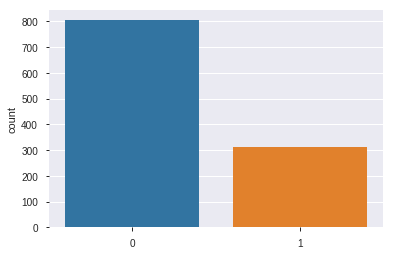

In [ ]:
sns.countplot(submission)

In [ ]:
sample.head()

driver_id  label
0  140333893      1
1  140500035      1
2  140434318      0
3  140568508      1
4  140492869      0

In [ ]:
weekly_test.head()

driver_id  total_transcations1_sum1  total_transcations1_mean1  \
0     140333893                       3.0                   0.428571   
784   140500035                       3.0                   0.428571   
1568  140434318                       0.0                   0.000000   
1580  140568508                       2.0                   0.285714   
2364  140492869                       2.0                   0.285714   

      total_transcations1_median1  total_transcations2_sum2  \
0                             0.0                       5.0   
784                           0.0                       5.0   
1568                          0.0                       0.0   
1580                          0.0                       2.0   
2364                          0.0                       1.0   

      total_transcations2_mean2  total_transcations2_median2  \
0                      0.714286                          0.0   
784                    0.714286                          0.0   
1568                   0.000000                          0.0   
1580                   0.285714                          0.0   
2364                   0.142857                          0.0   

      total_transcations3_sum3  total_transcations3_mean3  \
0                          1.0                   0.142857   
784                        0.0                   0.000000   
1568                       0.0                   0.000000   
1580                       5.0                   0.714286   
2364                       0.0                   0.000000   

      total_transcations3_median3            ...              \
0                             0.0            ...               
784                           0.0            ...               
1568                          0.0            ...               
1580                          0.0            ...               
2364                          0.0            ...               

      orders_cancelled1_median1  orders_cancelled2_sum2  \
0                           0.0                    26.0   
784                         0.0                     2.0   
1568                        0.0                     0.0   
1580                        0.0                     0.0   
2364                        0.0                     0.0   

      orders_cancelled2_mean2  orders_cancelled2_median2  \
0                    3.714286                        3.0   
784                  0.285714                        0.0   
1568                 0.000000                        0.0   
1580                 0.000000                        0.0   
2364                 0.000000                        0.0   

      orders_cancelled3_sum3  orders_cancelled3_mean3  \
0                        5.0                 0.714286   
784                      0.0                 0.000000   
1568                     0.0                 0.000000   
1580                     0.0                 0.000000   
2364                     0.0                 0.000000   

      orders_cancelled3_median3  orders_cancelled4_sum4  \
0                           0.0                     7.0   
784                         0.0                     0.0   
1568                        0.0                     0.0   
1580                        0.0                     7.0   
2364                        0.0                     0.0   

      orders_cancelled4_mean4  orders_cancelled4_median4  
0                         1.0                        0.0  
784                       0.0                        0.0  
1568                      0.0                        0.0  
1580                      1.0                        0.0  
2364                      0.0                        0.0  

[5 rows x 85 columns]

In [ ]:
submission[:4]

array([0, 0, 1, 0], dtype=int64)

In [ ]:
sample['label'] = submission

In [ ]:
sample.head()

driver_id  label
0  140333893      0
1  140500035      0
2  140434318      1
3  140568508      0
4  140492869      1

In [ ]:
sample.to_csv('cobacoba1.csv',index=False)